In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
coin = 'KRW-UXLINK'

In [4]:
df = pd.read_csv(f'../data/from_pyupbit/{coin}.csv')

In [5]:
df

,timestamp,open,high,low,close,volume,value
0,2024-09-03 22:05:00,200.0,499.0,200.0,390.0,3.339987e+07,1.492218e+10
1,2024-09-03 22:06:00,390.0,395.5,349.5,350.0,2.215647e+07,8.109357e+09
2,2024-09-03 22:07:00,349.8,366.0,344.2,361.0,1.029749e+07,3.709872e+09
3,2024-09-03 22:08:00,361.0,376.5,361.0,372.4,8.869899e+06,3.288303e+09
4,2024-09-03 22:09:00,372.4,376.8,368.8,368.9,6.204757e+06,2.316654e+09
...,...,...,...,...,...,...,...
55244,2024-10-12 21:06:00,737.5,738.8,737.4,738.8,1.832447e+04,1.351471e+07
55245,2024-10-12 21:07:00,738.4,740.5,738.4,739.6,1.084755e+04,8.023372e+06
55246,2024-10-12 21:08:00,740.4,740.5,739.5,739.9,2.903907e+04,2.148139e+07
55247,2024-10-12 21:09:00,739.9,740.7,739.9,740.0,5.953868e+03,4.407777e+06


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [7]:
df

,open,high,low,close,volume,value
timestamp,,,,,,
2024-09-03 22:05:00,200.0,499.0,200.0,390.0,3.339987e+07,1.492218e+10
2024-09-03 22:06:00,390.0,395.5,349.5,350.0,2.215647e+07,8.109357e+09
2024-09-03 22:07:00,349.8,366.0,344.2,361.0,1.029749e+07,3.709872e+09
2024-09-03 22:08:00,361.0,376.5,361.0,372.4,8.869899e+06,3.288303e+09
2024-09-03 22:09:00,372.4,376.8,368.8,368.9,6.204757e+06,2.316654e+09
...,...,...,...,...,...,...
2024-10-12 21:06:00,737.5,738.8,737.4,738.8,1.832447e+04,1.351471e+07
2024-10-12 21:07:00,738.4,740.5,738.4,739.6,1.084755e+04,8.023372e+06
2024-10-12 21:08:00,740.4,740.5,739.5,739.9,2.903907e+04,2.148139e+07


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, f'models/{coin}_scaler.pkl')

['models/KRW-UXLINK_scaler.pkl']

In [9]:
timestep = 1

In [10]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [11]:
X, y = np.array(X), np.array(y)

In [12]:
train_size = int(len(X) * .8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
1382/1382 [==============================] - 9s 5ms/step - loss: 0.0066 - val_loss: 3.6228e-06
Epoch 2/20
1382/1382 [==============================] - 6s 4ms/step - loss: 8.7828e-06 - val_loss: 4.2918e-06
Epoch 3/20
1382/1382 [==============================] - 6s 4ms/step - loss: 1.0023e-05 - val_loss: 1.4812e-05
Epoch 4/20
1382/1382 [==============================] - 6s 4ms/step - loss: 1.1489e-05 - val_loss: 4.7970e-06
Epoch 5/20
1382/1382 [==============================] - 6s 5ms/step - loss: 1.2401e-05 - val_loss: 3.4572e-06
Epoch 6/20
1382/1382 [==============================] - 12s 9ms/step - loss: 1.3147e-05 - val_loss: 1.5499e-05
Epoch 7/20
1382/1382 [==============================] - 14s 10ms/step - loss: 1.2752e-05 - val_loss: 4.0459e-06
Epoch 8/20
1382/1382 [==============================] - 14s 10ms/step - loss: 1.3013e-05 - val_loss: 1.9194e-05
Epoch 9/20
1382/1382 [==============================] - 14s 10ms/step - loss: 1.3886e-05 - val_loss: 5.1954e-06
Epoch 1

In [19]:
model.save(f'models/lstm_{coin}.h5')

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

346/346 [==============================] - 1s 1ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [22]:
test_predict

array([[767.94073],
       [767.94073],
       [765.85016],
       ...,
       [737.17194],
       [737.9687 ],
       [738.2675 ]], dtype=float32)

In [23]:
y_test

array([[769.7, 767.6, 767.8, ..., 739.6, 739.9, 740. ]])

In [24]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 2.64
Test RMSE: 2.20


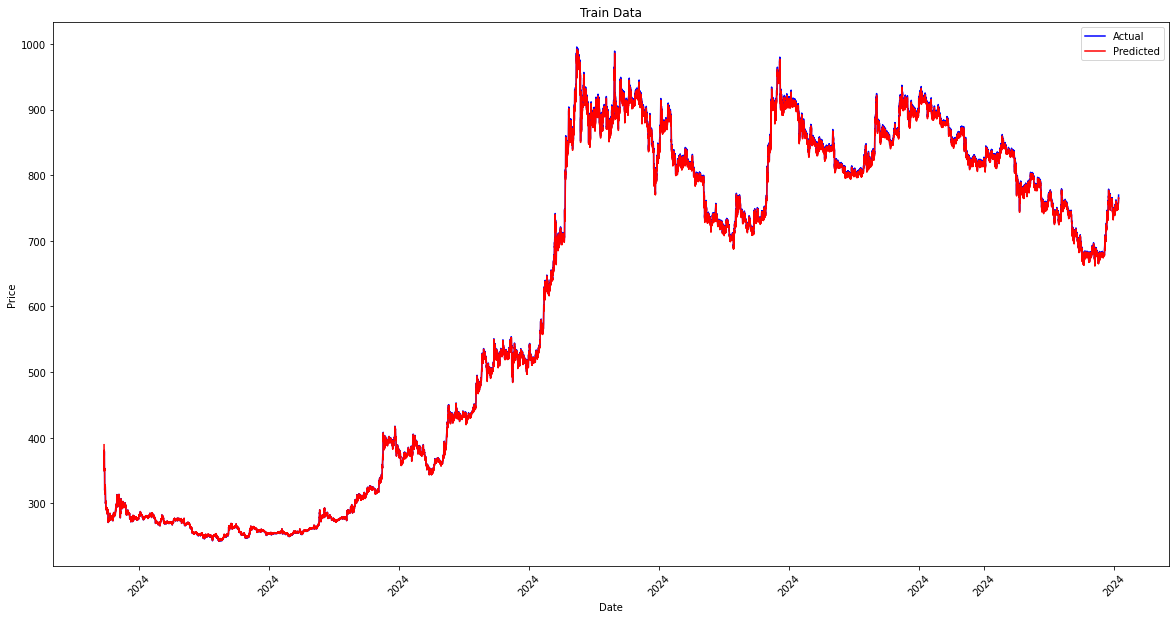

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

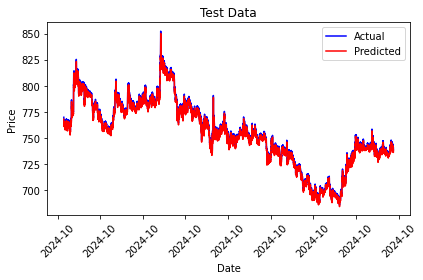

In [26]:
plt.subplot(1, 1, 1)
plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [27]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(last_1_day)

[[0.66184088]]


In [28]:
pred = model.predict(X_predict)
pred = scaler.inverse_transform(pred)
print(pred)

1/1 [==============================] - 0s 13ms/step
[[739.06433]]


In [29]:
preds = []
for i in range(30):
    pred = model.predict(X_predict)
    preds.append(scaler.inverse_transform(pred)[0][0])
    pred = pred.reshape(1, 1, 1)
    X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)

1/1 [==============================] - 0s 13ms/step


In [30]:
preds

[739.06433,
 737.4352,
 735.8125,
 734.1962,
 732.58624,
 730.9825,
 729.3848,
 727.79333,
 726.2079,
 724.62836,
 723.05475,
 721.487,
 719.92505,
 718.3688,
 716.81824,
 715.2732,
 713.73376,
 712.1998,
 710.6712,
 709.148,
 707.6302,
 706.1176,
 704.61017,
 703.108,
 701.61084,
 700.1187,
 698.63165,
 697.1495,
 695.67224,
 694.1999]